## MCMC for optimizing the 2-layer multiple output Neural Network

In [1]:
import emcee
import numpy as np
import matplotlib.pyplot as plt

Sanity checks for processor / GPU capabilities

In [ ]:
# Get CPU count
from multiprocessing import cpu_count
ncpu = cpu_count()
print("{0} CPUs".format(ncpu))

In [ ]:
# Checking GPU status
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [ ]:
import keras.backend as K
K.tensorflow_backend._get_available_gpus()

In [ ]:
import tensorflow as tf
#tf.config.optimizer_set_jit(True)

In [ ]:
tf.test.is_gpu_available()

In [ ]:
tf.test.gpu_device_name()

Testing out some emcee functionality
https://emcee.readthedocs.io/en/v2.2.1/

In [ ]:
#def lnprob(x, ivar):
#    return -0.5 * np.sum(ivar * x ** 2)

#ndim, nwalkers = 10, 100
#ivar = 1. / np.random.rand(ndim)
#p0 = [np.random.rand(ndim) for i in range(nwalkers)]

#sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[ivar])
#sampler.run_mcmc(p0, 10)

In [ ]:
#[np.random.rand(10) for i in range(10)]

Load previously trained NN models

In [ ]:
#import keras.backend as K
#def mean_sq_err(y_true,y_pred):
#    return K.mean((y_true-y_pred)**2)
#from keras.models import load_model
#model_GPP = load_model('emulators/NN_GPP_finalize_multi-dim.h5', 
#                       custom_objects={'mean_sq_err': mean_sq_err})
#model_LHF = load_model('emulators/NN_LHF_finalize_multi-dim.h5', 
#                       custom_objects={'mean_sq_err': mean_sq_err})

In [2]:
import keras.backend as K

Using TensorFlow backend.
/glade/work/kdagon/miniconda/envs/ML/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/glade/work/kdagon/miniconda/envs/ML/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/glade/work/kdagon/miniconda/envs/ML/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/glade/work/kd

In [3]:
def mean_sq_err(y_true,y_pred):
    return K.mean((y_true-y_pred)**2)

In [4]:
from keras.models import load_model

In [5]:
model_GPP = load_model('emulators/NN_GPP_finalize_multi-dim.h5', 
                       custom_objects={'mean_sq_err': mean_sq_err})

W0830 14:54:37.282660 140245971769088 deprecation_wrapper.py:119] From /glade/work/kdagon/miniconda/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0830 14:54:37.692800 140245971769088 deprecation_wrapper.py:119] From /glade/work/kdagon/miniconda/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0830 14:54:37.745589 140245971769088 deprecation_wrapper.py:119] From /glade/work/kdagon/miniconda/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0830 14:54:37.746618 140245971769088 deprecation_wrapper.py:119] From /glade/work/kdagon/miniconda/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:200: The name tf.ConfigProto 

In [6]:
model_LHF = load_model('emulators/NN_LHF_finalize_multi-dim.h5', 
                       custom_objects={'mean_sq_err': mean_sq_err})

List input variables

In [7]:
in_vars = ['medlynslope','dleaf','kmax','fff','dint','baseflow_scalar']
npar = len(in_vars)

Read in observational targets and calculated variance

In [8]:
obs_GPP = np.load(file="obs/obs_GPP_SVD_3modes.npy", allow_pickle=True)
obs_LHF = np.load(file="obs/obs_LHF_SVD_3modes.npy", allow_pickle=True)
sd_GPP = np.load(file="obs/obs_GPP_SVD_3modes_allyrs_sd.npy", allow_pickle=True)
sd_LHF = np.load(file="obs/obs_LHF_SVD_3modes_allyrs_sd.npy", allow_pickle=True)

Define normalized error function  

In [9]:
B=1.49 # midpoint of regimes
def normerr(x):
    xt = x.reshape(1,-1)
    model_preds_GPP = model_GPP.predict(xt)
    model_preds_LHF = model_LHF.predict(xt)
    L = -(np.sum(((model_preds_GPP-obs_GPP)/sd_GPP)**2, axis=1) + B*np.sum(((model_preds_LHF-obs_LHF)/sd_LHF)**2, axis=1))
    return L

In [56]:
# Cost function for GPP only
def normerr(x):
    xt = x.reshape(1,-1)
    model_preds_GPP = model_GPP.predict(xt)
    L = -(np.sum(((model_preds_GPP-obs_GPP)/sd_GPP)**2, axis=1))
    return L

In [65]:
# Cost function for LHF only
def normerr(x):
    xt = x.reshape(1,-1)
    model_preds_LHF = model_LHF.predict(xt)
    L = -(np.sum(((model_preds_LHF-obs_LHF)/sd_LHF)**2, axis=1))
    return L

Define the prior //
see also https://emcee.readthedocs.io/en/v2.2.1/user/line/#marginalization-uncertainty-estimation

In [66]:
def lnprior(x):
    #if x.any() >= 0 and x.any() <= 1:
    #if all(x > 0) and all(x < 1):
    if np.all(x > 0) and np.all(x < 1):
        return 0.0
    return -np.inf

Define full log prob function

In [67]:
def lnprob(x):
    lp = lnprior(x)
    if not np.isfinite(lp):
        return -np.inf
    return lp + normerr(x)

Number of walkers, number of dimensions = number of parameters

In [68]:
# Note that number of walkers is correlated with runtime
nwalkers = 50
ndim = npar

Initialize walkers (random initial states)

In [69]:
p0 = [np.random.rand(ndim) for i in range(nwalkers)]

Play around with different initializations

In [32]:
# Initialize all 0.5 - results in no movement from initial state (tested up to 1000 epochs)
#z0 = [np.zeros(ndim)+0.5 for i in range(nwalkers)]
#z0[0] = np.random.rand(ndim)

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

LHC generated random initial conditions

In [42]:
#from pyDOE import *
#lhd = lhs(npar,samples=1) # default sampling criterion = random
#len(lhd)
#x0 = lhd[0,:]
#print(x0)
#x0.shape
#xt = x0.reshape(1,-1)
#print(xt)
#p0=[x0]
#print(p0)

Set up sampler

In [78]:
# Serial
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

In [ ]:
# Multithreading
#sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=2)

Run Sampler

In [79]:
epochs = 1*10**4
result = sampler.run_mcmc(p0, epochs, progress=True)

100%|██████████| 10000/10000 [02:03<00:00, 81.00it/s]


In [ ]:
# Multiprocessing
#from multiprocessing import Pool
#with Pool(processes=2) as pool:
#    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, pool=pool) 
#    epochs = 1*10**3
#    sampler.run_mcmc(p0, epochs, progress=True)

In [39]:
sampler.chain.shape # nwalkers x epochs x ndim
sampler.chain[0,epochs-1,:] # final values for first walker

array([4.91391038e-01, 9.99970193e-01, 6.28537082e-06, 9.99820417e-01,
       9.99819866e-01, 1.57338051e-04])

Plot results

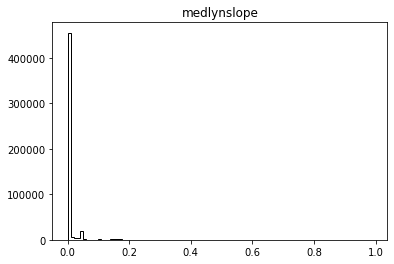

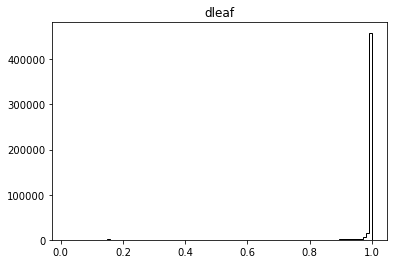

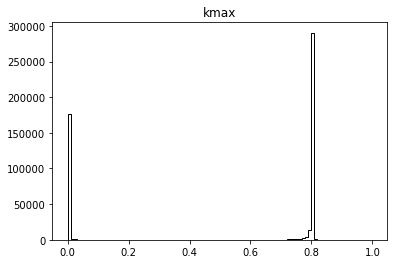

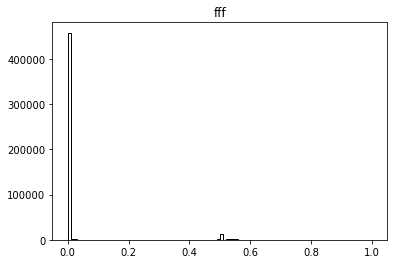

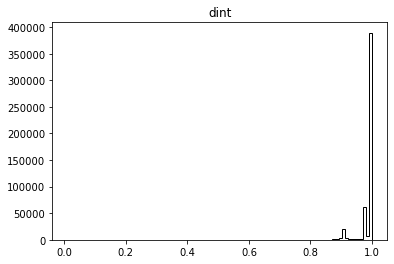

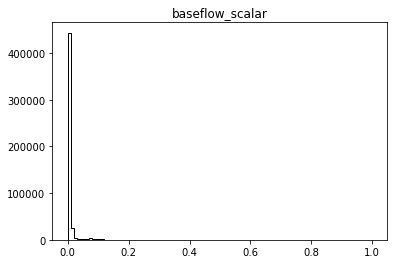

In [80]:
for i in range(ndim):
    plt.figure()
    plt.hist(sampler.flatchain[:,i], 100, color="k", histtype="step")
    #plt.title("Dimension {0:d}".format(i))
    plt.title(in_vars[i])
plt.show()

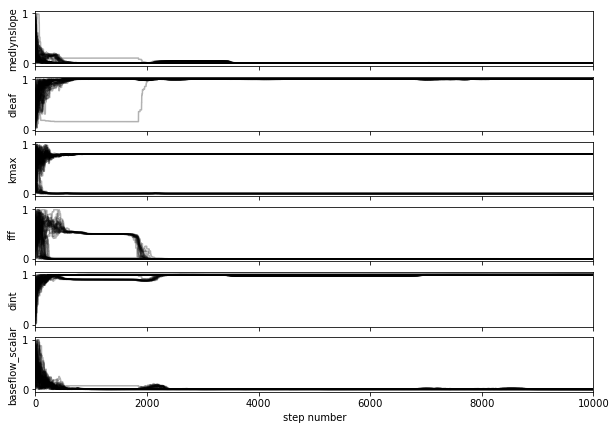

In [81]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples_all = sampler.get_chain()
labels = in_vars
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples_all[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples_all))
    ax.set_ylabel(labels[i])
    
axes[-1].set_xlabel("step number")
plt.show()

In [ ]:
print("Mean acceptance fraction: {0:.3f}"
                .format(np.mean(sampler.acceptance_fraction)))

In [ ]:
# discard the initial N steps
#samples = sampler.chain[:, 500:, :].reshape((-1, ndim))
flat_samples = sampler.get_chain(discard=10, flat=True)
import corner
fig = corner.corner(flat_samples, labels=in_vars)
#fig.savefig("MCMC_v1.pdf")

Get last sample

In [ ]:
#last_sample = sampler.get_last_sample() # can't figure out how to access this data structure
#dir(last_sample)
#last_sample.__class__
#print(last_sample)
last_sample = sampler.chain[:,epochs-1,:] # final values for all walkers
#print(last_sample.shape)
#np.save("MCMC_last_sample", last_sample)

In [ ]:
posterior = np.load("MCMC_last_sample.npy")
#posterior.shape
#plt.plot(posterior[:,3])